<h1> Bitcoin Time Series Modelling</h1>

The purpose of this project is to explore the application of the library Phophet on Bitcoins price action (from CryptoWatch API), to gain familiarity with the library and to create useful functions for both retriving cryptocurrency data, and evaluating prophet models.

<h3> Key Outcomes</h3>
<ul>
<li>Built foundational methodology of using Prophet for additive time series analysis  </li>
<li>Created a function to call cryptocurrnecy price data at specified granularity using CryptoWatch API </li>
<li>Created a function to find rolling pearsons correlation coefficient of two time series' over specified timeframe  </li>
<li>Evaluted Prophet change point relevancy to google trends interest </li>
<li>Created a function to compare different Prophet models via changepoint_prior_scale hyperparameter tuning </li>
<li>Bitcoin Prophet Hyperparameter Tuning </li>
    
    
</ul>

<h3> Contents </h3>
<ul>
<li>Bitcoin Price Action Retrieval from CryptoWatch API </li>
<li>Exploratory Rolling Pearson's Correlation Analysis With Index Funds </li>
<li>Bitcoin Prophet Introduction </li>
<li>Bitcoin Prophet Hyperparameter Tuning </li>
<li>Change Point Comparison with Google Trend Data  </li>
<li>Evaluating Prophet Model Predictions of Index Fund Prices  </li>

</ul>

<h2> Bitcoin Price Action Retrieval from CryptoWatch API </h2>

In [1]:
import cryptowatch as cw
import pandas as pd 
import matplotlib.pyplot as plt
print("All libraries imported successfully")

#set api key
cw.api_key = 'QSIYN3W065D5BWUA7AFR'

#create a function to get price action of any market, exchange and period combination 
def get_price_action(exchange, market, period):
    candles=cw.markets.get("{}:{}".format(exchange, market)
                           , ohlc=True
                           , periods=["{}".format(period)])
    df = pd.DataFrame(getattr(candles, 'of_{}'.format(period)))
    df.columns=(["date","open", "high", "low", "close", "volume", "volume in {}".format(market[-3:])])
    df["date"] = pd.to_datetime(df["date"], unit='s')
    df.set_index("date", inplace=True)
    return df

print("Function defined sucessfully")


All libraries imported successfully
Function defined sucessfully


Text(0, 0.5, 'BTC Price/USD')

Text(0.5, 0, 'Date')

Text(0, 0.5, 'BTC Volume/BTC')

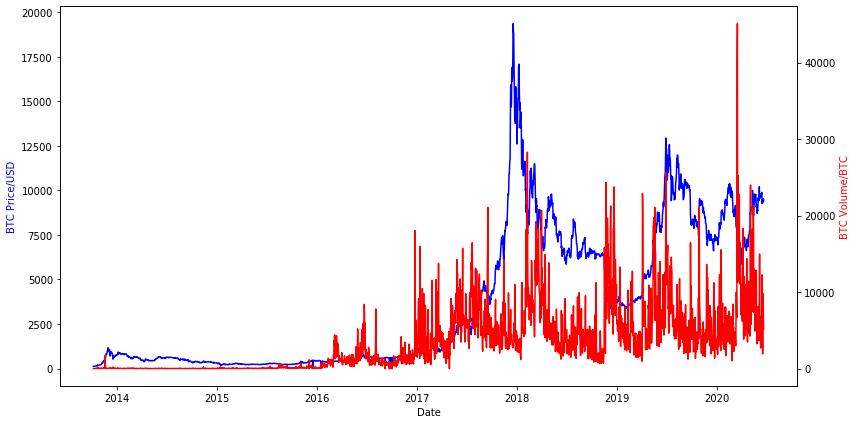

In [2]:
#pull weekly bitcoin price action and plot vs volume
df_btc_usd_kraken_1d = get_price_action(exchange="KRAKEN"
                                    ,market = "BTCUSD"
                                    ,period = '1d')
#set BTC price/time axis
fig, ax1 = plt.subplots(figsize = (12,6))
color = 'tab:blue'
ax1.set_ylabel('BTC Price/USD', color='blue')
ax1.set_xlabel('Date')
ax1.plot(df_btc_usd_kraken_1d.index
        ,df_btc_usd_kraken_1d["close"]
        ,color = 'blue')

#add second axis for volume
ax2 = ax1.twinx()

ax2.set_ylabel('BTC Volume/BTC', color='red')
ax2.plot(df_btc_usd_kraken_1d.index
         ,df_btc_usd_kraken_1d["volume"]
         ,color= 'red')
fig.tight_layout()

plt.show()


Expected result. High volume spikes align with high weekly price volatility (postitive and negative). Interesting note that at Bitcoin's highest price (~19000 USD) we see very little volume. I.e. not many traders managed to sell at the very top, most early sellers sold at ~$13000. 

<h2> Exploratory Rolling Pearson's Correlation Analysis With Index Funds</h2>

Inspired by analysis at TheBlock, I created a function to easily generate rolling correlation plots of two time series', to see if and when assets are correlated. 

The function takes two dataframes, the respective column names of interest and the specified period size. The dataframes require the highest level of granularity to be set as the dataframe index, and works best with hourly data.

In [3]:
from scipy.stats import pearsonr

#Define function that takes two time series dataframes, marges them, splits into specified timeframe and 
#finds rolling correlation coefficient split by that timeframe
#The function can fail if a granularity is chosen with only one datapoint 
#i.e. (if you select weekly correlations, but only have 1 day in a certain wekk)

def cointegration_function(df1, var1, df2, var2, timeframe):
    #slice the dataframes, ensure both indexes are named same and joining to one dataframe 
    df1_slice = df1.loc[:, ['{}'.format(var1)]]
    df2_slice = df2.loc[:, ['{}'.format(var2)]]
    df1_slice.index.name = 'date'
    df2_slice.index.name = 'date'
    df_comb = pd.merge(df1_slice, df2_slice, on='date')
    #add week/month/day numbers 
    df_comb['day'] = df_comb.index.strftime('%x')
    df_comb['week'] = df_comb.index.strftime('%Y-%W')
    df_comb['month'] = df_comb.index.strftime('%Y-%m')
    
    #create empty dict for results 
    results = {}
    #split into timeframe, and calc correlation coefficient for all data points in that timeframe
    #if statement error-handles for variables that are named the same
    if var1 == var2:
        for tf in df_comb['{}'.format(timeframe)].unique():
            timeframe_data = df_comb[df_comb['{}'.format(timeframe)] == tf]
            corr = pearsonr(timeframe_data['{}'.format(var1 + '_x')], timeframe_data['{}'.format(var2 + '_y')])
            results[tf] = [corr[0]]
    else: 
  #split into timeframe, and calc correlation coefficient for all data points in that 
        for tf in df_comb['{}'.format(timeframe)].unique():
            timeframe_data = df_comb[df_comb['{}'.format(timeframe)] == tf]
            corr = pearsonr(timeframe_data['{}'.format(var1)], timeframe_data['{}'.format(var2)])
            results[tf] = [corr[0]]
    result_df = pd.DataFrame.from_dict(results, orient='index', columns=['pearsons_coeff'])
    result_df.index.name = 'timeframe'
    
    return result_df

print("Function defined sucessfully")

Function defined sucessfully


In [4]:
import yfinance as yf
from scipy.stats import pearsonr

#set tickers
tickers = {'NASDAQ' : '^IXIC'
           ,'S&P' : '^GSPC'
           ,'DOW' : '^DJI'}

#pulling in nasdaq data
nasdaq = yf.Ticker(tickers['NASDAQ'])
nasdaq_df = pd.DataFrame(nasdaq.history(period='max'))

#pulling in BTC data 
#can only get daily close data for NASDAQ
#therefore need to match with daily BTC data
btc_usd_coinbase_1d = get_price_action(exchange='COINBASE'
                                       ,market = 'BTCUSD'
                                       ,period='1d')

nasdaq_btc_monthly_corr = cointegration_function(nasdaq_df
                                                 ,'Close'
                                                 ,btc_usd_coinbase_1d
                                                 ,'close'
                                                 ,timeframe='month')

#inspect output 
nasdaq_btc_monthly_corr.head()

,pearsons_coeff
timeframe,
2015-01,0.174409
2015-02,0.603612
2015-03,-0.128183
2015-04,-0.575840
2015-05,-0.272974


Text(0.5, 0, 'Month')

Text(0, 0.5, "Pearson's Correlation Coefficient")

(735599.0, 737577.0)

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Bitcoin Price/USD & NASDAQ Points')

Text(0.5, 0, 'Date')

Text(0, 0.5, "Pearson's Correlation Coefficient")

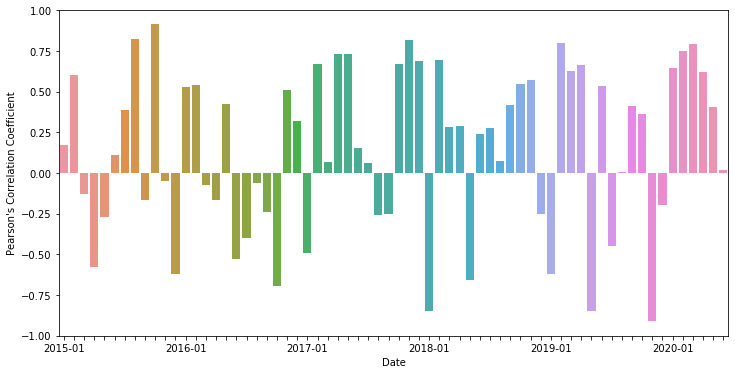

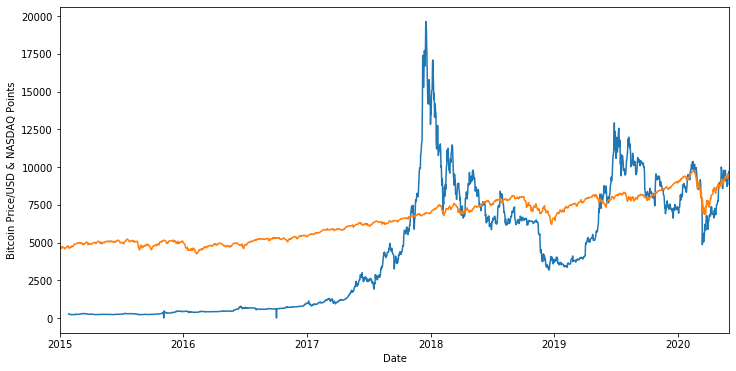

In [5]:
#plot monthly correlation coefficients 
import seaborn as sns
from datetime import datetime, timedelta

fig1, ax1 = plt.subplots(figsize=(12,6))

sns.barplot(x = nasdaq_btc_monthly_corr.index
                ,y = nasdaq_btc_monthly_corr['pearsons_coeff']
                ,ax =ax1)
ax1.set_xlabel("Month")
ax1.set_ylabel("Pearson's Correlation Coefficient")

#only take every 12th x label due to overlap 
for i, t in enumerate(ax1.get_xticklabels()):
    if (i % 12) != 0:
        t.set_visible(False)

#compare against price graphs 
fig2, ax2 = plt.subplots(figsize=(12,6))

sns.lineplot(x = btc_usd_coinbase_1d.index
            ,y = btc_usd_coinbase_1d['close']
            ,ax=ax2)

sns.lineplot(x = nasdaq_df.index
           ,y= nasdaq_df['Close']
           ,ax=ax2)

ax2.set_xlim([datetime(2015, 1, 1), datetime(2020, 6, 1)])
ax2.set_xlabel("Date")
ax2.set_ylabel("Bitcoin Price/USD & NASDAQ Points")

ax1.set_xlabel("Date")
ax1.set_ylabel("Pearson's Correlation Coefficient")


plt.show()

Really interesting results. We can clearly isolate time periods where both time series' correlated strongly. More recently in 2020, we see a somewhat meaningful correlation between NASDAQ and BTC. While this could have some relevancy - "retail" buyers liquidating speculative assests during COVID-19 uncertainty/crash and subsequently rebuying at supposed NASDAQ bounce - we must be VERY careful in drawing any sort of actionable conclusions. It is an interseting observation NOT intended to support any financial decision, but the function used to draw this insight is applicable in many other points of view.

<h2> Bitcoin Prophet Introduction </h2>

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


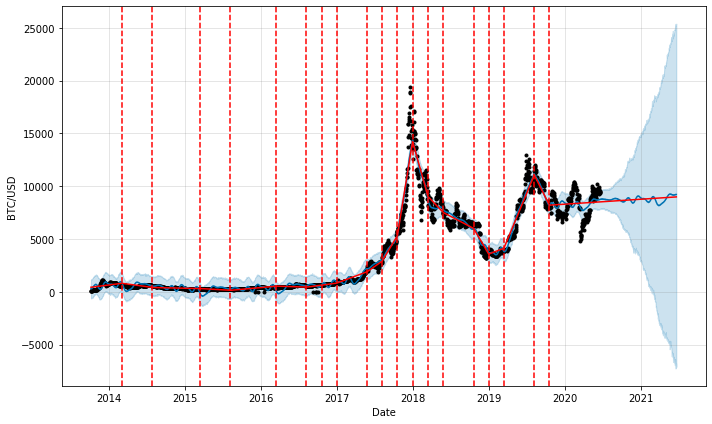

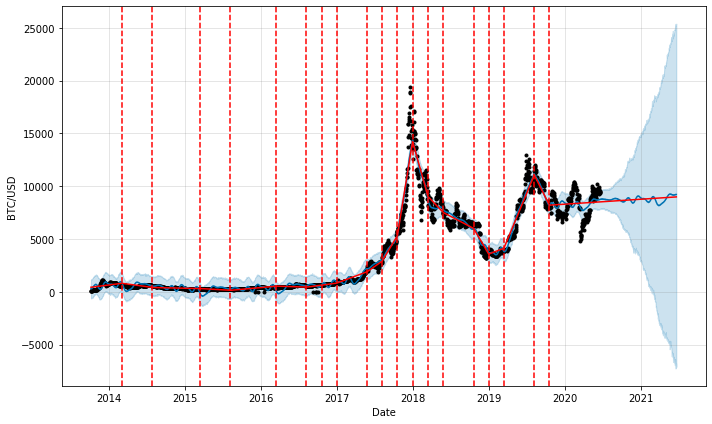

In [6]:
import fbprophet 
from fbprophet.plot import add_changepoints_to_plot

#call daily BTCUSD price action
btc = get_price_action(exchange="KRAKEN"
                      ,market = "BTCUSD"
                      ,period = '1d')

#replace date and close data names for prophet
btc.reset_index(inplace=True)
btc.rename(columns={'close':'y', 'date': 'ds'}, inplace=True)

#create the model and fit the data 
#changepoint_prior_scale is used to control how sensitive the trend is to change
#higher = more sensitive  lower = less sensitive 
btc_prophet = fbprophet.Prophet(changepoint_prior_scale=0.15
                                ,changepoint_range=0.9 # also setting checkpoitns for 90% (up from 80%) of range
                                ,n_changepoints=30 #specified amount won't necessarily appear in add_changepoints_to_plot, but will always appear once you inspect the .changepoints attribute
                                )
btc_prophet.fit(btc)

#create a dataframe with new dates 
btc_forecast = btc_prophet.make_future_dataframe(periods = 365
                                               ,freq = 'D')

#make predictions in the new dataframe
btc_forecast = btc_prophet.predict(btc_forecast)

fig = btc_prophet.plot(btc_forecast
                ,xlabel = 'Date'
                ,ylabel = 'BTC/USD')

#adding the changepoints from the model
_ = add_changepoints_to_plot(fig.gca()#this gets axis from figure
                            ,btc_prophet
                            ,btc_forecast)

fig


<h2> Bitcoin Prophet Model Hyperparameter Tuning </h2>


We now need to show the effiacy of the model by also plotting test data, look to improving the model by adjusting the hyperprameter changepoint_prior_scale. We can create a function which will plot the prophet model vs test dataset for any specified changepoint_prior_scale, to easily compare models. 

2020-06-17 23:28:04,641 - cryptowatch - INFO - Getting market OHLC candles KRAKEN:BTCUSD
INFO:cryptowatch:Getting market OHLC candles KRAKEN:BTCUSD
2020-06-17 23:28:05,139 - cryptowatch - INFO - API Allowance: cost=2612422 remaining=3955552471
INFO:cryptowatch:API Allowance: cost=2612422 remaining=3955552471
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Starting model for cpps:0.2


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Starting model for cpps:0.4


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Starting model for cpps:0.6


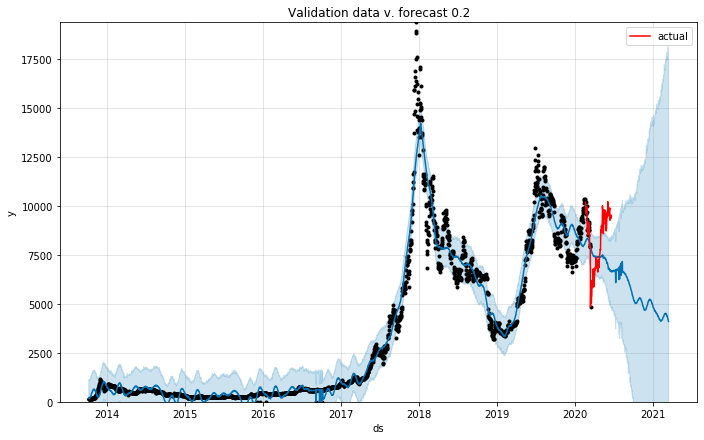

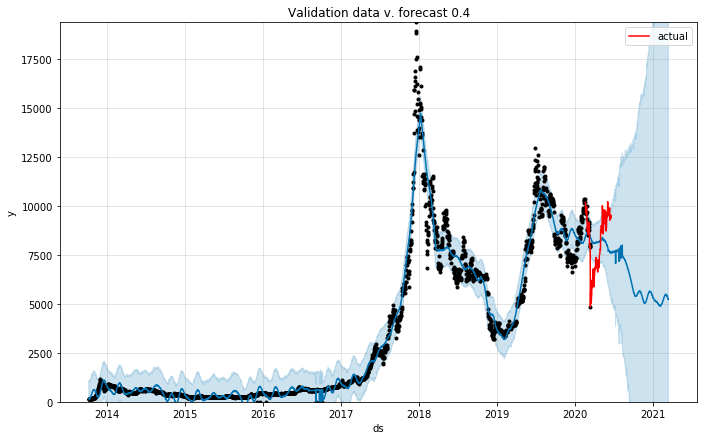

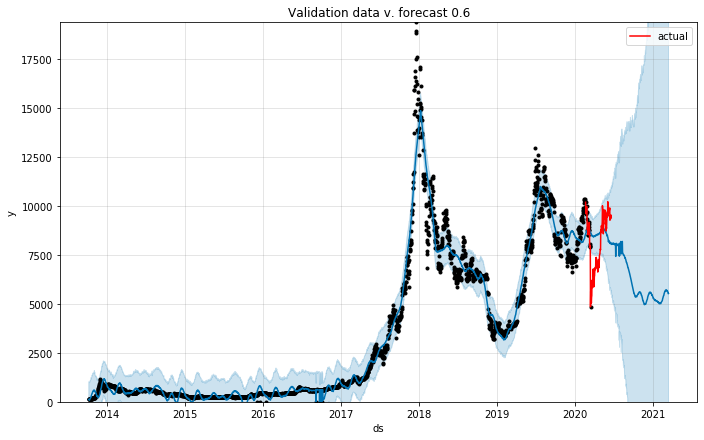

In [7]:
#call daily BTCUSD price action
btc = get_price_action(exchange="KRAKEN"
                      ,market = "BTCUSD"
                      ,period = '1d')

#replace date and close data names for prophet
btc.reset_index(inplace=True)
btc.rename(columns={'close':'y', 'date': 'ds'}, inplace=True)

#adding halving dates to model
halvings = pd.DataFrame({
  'holiday': 'halving',
  'ds': pd.to_datetime(['2012-11-28', '2016-07-09', '2020-05-11']),
  'lower_window': 0,
  'upper_window': 90,
})

#this function takes a specified dataframe, splits into training and test dataframes (specify size), 
#and compares different hyperparameters by plotting each model and visualising the result
def find_optimal_prophet_model(df
                              ,cpps
                              ,special_events
                              ,periods
                              ,freq
                              ,test_size):
    #split off last 10% for validation 
    df_train= df.sort_values('ds', ascending=True).head(int(len(btc)*((1-test_size)/100)))
    df_test = df.sort_values('ds', ascending=True).tail(int(len(btc)*(test_size/100)))

    #for each hyperparameter
    for param in cpps:
        print("Starting model for cpps:{}".format(param))
        #create the model
        model = fbprophet.Prophet(changepoint_prior_scale=param
                                        ,changepoint_range=0.9
                                        ,n_changepoints=30 
                                        ,holidays=special_events)
        #fit the model
        model.fit(df_train)
        
        #create forcast by extrapolating training data
        future_df_train = model.make_future_dataframe(periods = periods
                                                       ,freq = '{}'.format(freq))
        
        #fit the model on the extrapolated training data 
        forecast_train = model.predict(future_df_train)
        
        #plot the model with predicted value
        model.plot(forecast_train, uncertainty=True)
        
        #plot actual dataset to compare 
        plt.plot(df_test['ds']
                ,df_test['y']
                ,label = 'actual'
                ,color = 'r')

        plt.title('Validation data v. forecast {}'.format(param))
        plt.ylim(df['y'].min(), df['y'].max())
        plt.legend();
        
cpps=(0.2, 0.4, 0.6
      )

find_optimal_prophet_model(df=btc
                              ,cpps=cpps
                              ,special_events=halvings
                              ,periods=365
                              ,freq='D'
                              ,test_size=5)


Somewhat expected results - the model does cannot react to Bitcoins high volatility and the sentiment sensitive traders. It would be foolish to expect an out-of-the-box model to be able to, but we can visualise the reasons why this is the case using these plots. Regardless, we have created an effective function to tune the changepoint_prior_scale hyperparameter for future projects. 

<h2> Changepoint Comparison with Google Trends </h2>

2020-06-17 23:31:30,245 - cryptowatch - INFO - Getting market OHLC candles KRAKEN:BTCUSD
INFO:cryptowatch:Getting market OHLC candles KRAKEN:BTCUSD
2020-06-17 23:31:30,698 - cryptowatch - INFO - API Allowance: cost=2553142 remaining=3948170585
INFO:cryptowatch:API Allowance: cost=2553142 remaining=3948170585
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Text(0, 0.5, 'Worldwide Relative Bitcoin Index')

Text(0.5, 0, 'Date')

[(0, 100)]

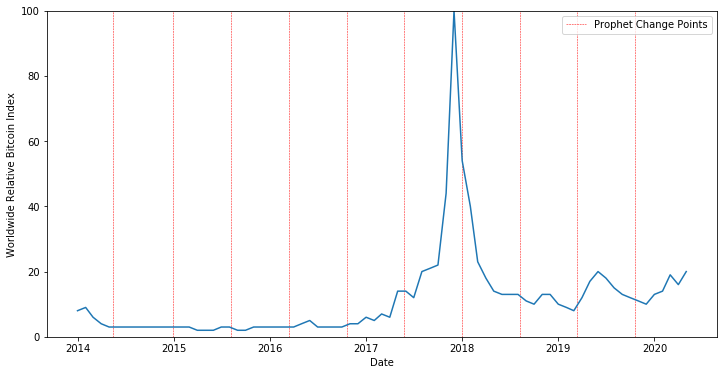

In [10]:
#call daily BTCUSD price action
btc = get_price_action(exchange="KRAKEN"
                      ,market = "BTCUSD"
                      ,period = '1d')

#replace date and close data names for prophet
btc.reset_index(inplace=True)
btc.rename(columns={'close':'y', 'date': 'ds'}, inplace=True)

#create the model and fit the data 
#changepoint_prior_scale is used to control how sensitive the trend is to change
#higher = more sensitive  lower = less sensitive 
btc_prophet = fbprophet.Prophet(changepoint_prior_scale=0.15
                                ,changepoint_range=0.9 # also setting checkpoitns for 90% (up from 80%) of range
                                ,n_changepoints=10 #specified amount won't necessarily appear in add_changepoints_to_plot, but will always appear once you inspect the .changepoints attribute
                                )
btc_prophet.fit(btc)

trends = pd.read_csv("C:/Users/Michael/Documents/GitHub/bitcoin-time-series-modeling-/bitcoin_google_trends.csv")
trends['Month'] = pd.to_datetime(trends['Month'])

btc_daily_changepoints = pd.DataFrame([pd.to_datetime(date) for date in btc_prophet.changepoints])
fig, ax = plt.subplots(figsize=(12, 6))

sns.lineplot(trends['Month']
           ,trends['worldwide_relative_bitcoin_interest']
           ,ax=ax)
plt.ylabel('Worldwide Relative Bitcoin Index')
plt.xlabel('Date')

ax.vlines(btc_daily_changepoints[0]
          ,ymin = -5
          ,ymax = 100
          ,colors = 'r'
          ,linewidth = 0.5, linestyles = 'dashed', label='Prophet Change Points')

ax.set(ylim=(0, 100))
ax.legend()
plt.show()




The changepoints automatically detect abrupt changes in the time series tragectory. It is interesting to see that large changepoints are sometimes followed by a large deviation in google interest, possibly hinting to more media coverage magnifying any short term prices changes in both directios.  

<h2> Evaluating Prophet Model Predictions of Index Fund Prices </h2>


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Text(0.5, 0, 'Month')

Text(0, 0.5, "Pearson's Correlation Coefficient")

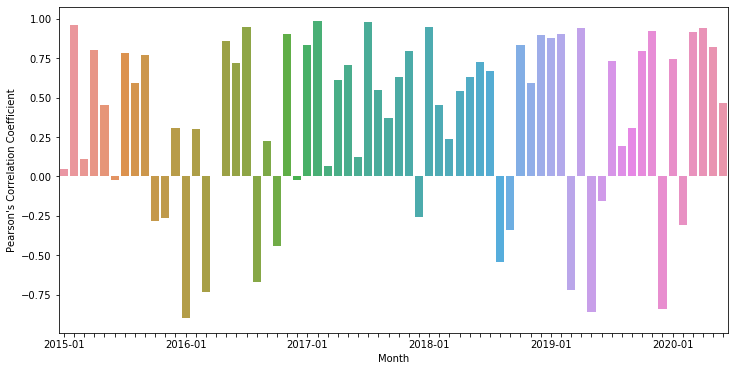

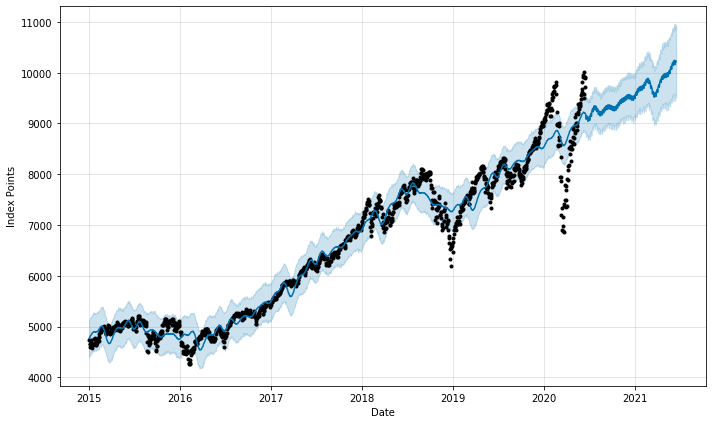

In [9]:

#since the model performed poorly on Bitcoin data, lets choose a less (but still somewhat) volatile market - indexes

#set tickers
tickers = {'NASDAQ' : '^IXIC'
           ,'S&P' : '^GSPC'
           ,'DOW' : '^DJI'}

#pulling in nasdaq data
index_ticket = yf.Ticker(tickers['NASDAQ']) #choose index here
index_df = pd.DataFrame(index_ticket.history(period='max'))

#reduce timeframe and change format
index_df = index_df[index_df.index >= '2015-01-01']
index_df.reset_index(inplace=True)
index_df.rename(columns={'Date' : 'ds', 'Close' : 'y'}, inplace=True)


#Evaulate prophet model vs test data using rolling correlation function

#create the model and fit the data 
#changepoint_prior_scale is used to control how sensitive the trend is to change
#higher = more sensitive  lower = less sensitive 
index_prophet = fbprophet.Prophet(changepoint_prior_scale=0.05
                                ,changepoint_range=0.9 # also setting checkpoitns for 90% (up from 80%) of range
                                ,n_changepoints=30 #specified amount won't necessarily appear in add_changepoints_to_plot, but will always appear once you inspect the .changepoints attribute
                                )
index_prophet.fit(index_df)

#create a dataframe with new dates 
index_forecast = index_prophet.make_future_dataframe(periods = 365
                                               ,freq = 'D')

#make predictions in the new dataframe
index_forecast = index_prophet.predict(index_forecast)

#obtain prophet predictions 
index_predictions = index_forecast.loc[:, ('ds', 'yhat')] #yhat is prophets prediction
index_predictions.rename(columns={'ds' : 'date'}, inplace=True)
index_predictions.set_index('date', inplace=True)

#recall price action before format changes
index_ticket = yf.Ticker(tickers['NASDAQ'])
index_df = pd.DataFrame(index_ticket.history(period='max'))
index_df = index_df[index_df.index >= '2015-01-01']


#find correlations

prophet_preditions_vs_actual_correlation = cointegration_function(index_predictions
                                                 ,'yhat'
                                                 ,index_df
                                                 ,'Close'
                                                 ,timeframe='month')

#plot monthly correlation coefficients 
fig1, ax1 = plt.subplots(figsize=(12,6))

sns.barplot(x = prophet_preditions_vs_actual_correlation.index
                ,y = prophet_preditions_vs_actual_correlation['pearsons_coeff']
                ,ax =ax1)
ax1.set_xlabel("Month")
ax1.set_ylabel("Pearson's Correlation Coefficient")

#only take every 12th x label due to overlap 
for i, t in enumerate(ax1.get_xticklabels()):
    if (i % 12) != 0:
        t.set_visible(False)

plt.show()

#compare with model visuslisation 
fig = index_prophet.plot(index_forecast
                ,xlabel = 'Date'
                ,ylabel = 'Index Points')


Generally speaking, the model correlates in a somewhat meaningful way in the less volatile markets. Since 2020 has been such a dramatic year for the stock market with a clear V shaped crash and recovery, it again would be ambitious to expect a single out-of-the-box model to be able to provide any insight into their future behaviour. ONe key takeaway I have noticed from the BTC and index functions is that the Prophet model does seem to algin with the bull/bear market theories. I.e. a market which has been consistently reaching higher highs will continue to rise, and a market exhibiting a even a few lower-lows will start to see a pullback. While this alone cannot/should not be used to make any resemblence of a financial decision, it could confirm my initial bias that attempting to time the market and buy at the perfect time is far inferior to trading the trend. Wait for strong confirmations of bull/bear markets after prices close above key, high timeframe levels and dollar cost average into assests with strong fundamental value.